# 4.1 PopNet Simulation with SSN


Original work by Rubin et al.: [The Stabilized Supralinear Network: A Unifying Circuit Motif Underlying Multi-Input Integration in Sensory Cortex](https://doi.org/10.1016/j.neuron.2014.12.026)

Application study by Ito et al.: [Coordinated changes in a cortical circuit sculpt effects of novelty on neural dynamics](https://doi.org/10.1016/j.celrep.2024.114763)

$$
\tau_j \frac{dr}{dt} = -r_j + (s(\sum_i J_{ji} r_{i} + J_{E}r_{E}) + b_{j})_+^2 \tag{1}
$$


In [1]:
%%html
<style>table {float:left;display:block}</style>



## Building and Saving the network

First step is to either build a new, or download an existing, network of nodes and edges to simulate. We will use the BMTK [NetworkBuilder](https://alleninstitute.github.io/bmtk/tutorials/NetworkBuilder_Intro.html) to create a standard network and save it to the SONATA network file format. Unlike simulators like BioNet or PointNet, which deals with networks of individual spiking cells - PopNet simulates the firing-rate dynamics between subpopulations/cell-types. As such when we build each sub-population using ```add_nodes``` method we only have 1 cell in a population (eg. We let the ```N``` parameter default to value **1**).

It is also possible to use PopNet with an existing network containing individual cells, as long as we specify during simulation how to group individual cells into populations, which we will demonstrate below. (**NOTE**: If using a BioNet or PointNet network with PopNet you will also need to update and map parameters, which at the moment needs to be preformed manually).

### Building Recurrent Networks

We will first build and save a model representing the major cell types found in the mouse cortex L2/3. We start by instantiating a network called "l23" and addng the four major cell populations whose firing-rates dynamics will be calculated during simulation

In [1]:
from bmtk.builder import NetworkBuilder


l23_net = NetworkBuilder('l23')
l23_net.add_nodes(
    pop_name='Exc',
    ei='e',
    model_template='ssn:Recurrent',
    model_type='rate_population',
    scaling_coef=22.392148198236782,
    exponent=2.0,
    decay_const=10.0500429106779
)
l23_net.add_nodes(
    pop_name='PV',
    ei='i',
    model_template='ssn:Recurrent',
    model_type='rate_population',
    scaling_coef=22.392148198236782,
    exponent=2.0,
    decay_const=11.8257398864811
)

l23_net.add_nodes(
    pop_name='SST',
    ei='i',
    model_template='ssn:Recurrent',
    model_type='rate_population',
    scaling_coef=22.392148198236782,
    exponent=2.0,
    decay_const=10.0159482249032
)

l23_net.add_nodes(
    pop_name='VIP',
    ei='i',
    model_template='ssn:Recurrent',
    model_type='rate_population',
    scaling_coef=22.392148198236782,
    exponent=2.0,
    decay_const=49.3117045605402
)

Each of the four node-populations are set using a combination of optional and required attributes which will be used to instantate the cells in the network.

* **pop_name** and **ei** are *optional* attributes we assign to each population, will be useful during analysis and 
* We must set **model_type** to ```rate_population``` and **model_template** to ```ssn:Recurrent``` to indicate to PopNet how to instantiate each sub-population.
* **scaling_coeff** is the connectivity scaling factor of the network: variable $s$ in eq (1)
* **decay_const** is the decay rate of the popuatlion: $\tau$ in eq (1)
* **exponent** is the exponent calcuated at each time step (defaul 2)
* **init_state** is the *optional* default initial state ($r_0$ in eq (1)). Although this value can be overwritten at the start of each simulation (see below).

---

#### [OPTIONAL] Dynamic Parameters File

The above network will save the relevant PopNet simulation parameters - **scaling_coeff**, **decay_const**, **exponent**, and **init_state** inside the SONATA network file. It is also possible to use the ```dynamic_params``` keyword to store and load parameters from an external json file. For example you can also use:

```python

l23_net.add_nodes(
    pop_name='Exc',
    ei='e',
    model_template='ssn:Recurrent',
    model_type='rate_population',
    dynamics_params='Exc_ssn_params.json'
)
```

Where **Exc_ssn_params.json** is a json file

```json
{
    scaling_coef=22.392148198236782,
    exponent=2.0,
    decay_const=49.3117045605402,
    init_state=0.0
}
```

Both options will work with PopNet and produce the same results. Using ```dynamics_params``` makes it easier to adjust and swap out parameters on the fly, but can add complexity to the simulation and could potentially lead to issues with reproducability.

---

Now we want to add connections between populations using the ```add_edges``` method. For each population we only need to indicate the **source** sub-population, the **target** population, and the **connection-strength** ($J_{ij}$).

After we set the connections we can build and save the network to the *network/* directory.


In [2]:
import pandas as pd
import numpy as np
import itertools

matrix = [
    # Connection weights have been pre-calculated
    [ 0.032540014514440,  0.04043037008531871,  0.07409100928480848,  0.054303329629300665],
    [-0.009474168446121, -0.01234075896522014, -0.00496813087571539,                   0.0],
    [-0.001201518371451, -0.00271476061802006, -0.00061333573436626, -0.014630226522887473],
    [-0.000305028126569, -0.00073158484138907, -0.00777536182340318, -0.0001246269351861529]
]
connections_df = pd.DataFrame(np.array(matrix), columns=['Exc', 'PV', 'SST', 'VIP'], index=['Exc', 'PV', 'SST', 'VIP'])

for src, trg in itertools.product(['Exc', 'PV', 'SST', 'VIP'], repeat=2):
    l23_net.add_edges(
        source={'pop_name': src}, 
        target={'pop_name': trg},
        syn_weight=connections_df.loc[src][trg]
    )

l23_net.build()
l23_net.save(output_dir='network')

### Building External Inputs

Now we also want to create inputs that can be used to drive our network ($b_j$). In our model we will have inputs from two separate networks; subcortical inputs (**bkg**) and inputs from the local L4 cells (**l4**). We create these two networks like we do with the recurrent - but the caveat that we must set ```model_type=virtual``` which will indicate to PopNet that these aren't populations to simulate, but rather virutal "placeholders" that will be used for input stimulus (which we can define at run-time).


In [3]:
# Create L4 --> L2/3 connections
l4e_net = NetworkBuilder('l4e')
l4e_net.add_nodes(
    model_template='ssn:External',
    model_type='virtual'
)

for trg, syn_weight in zip(['Exc', 'PV', 'SST', 'VIP'], [0.01256496, 0.0278943, 0.0034658, 0.01172155]):
    l4e_net.add_edges(
        target=l23_net.nodes(pop_name=trg),
        syn_weight=syn_weight
    )

l4e_net.build()
l4e_net.save(output_dir='network')


# Create BKG --> L2/3 connections
bkg_net = NetworkBuilder('bkg')
bkg_net.add_nodes(
    model_template='ssn:External',
    model_type='virtual'
)
for trg, syn_weight in zip(['Exc', 'PV', 'SST', 'VIP'], [0.00869301, 0.00013383, 0.00177394, 0.01785412]):
    bkg_net.add_edges(
        target=l23_net.nodes(pop_name=trg),
        syn_weight=syn_weight
    )
bkg_net.build()
bkg_net.save(output_dir='network')

## Setting up and running a simulation

Once we have built or imported a set of network file(s) we can go ahead and start the simulation. We must tell BMTK where find the network files for simulation, as well as what inputs/stimuli to use, and how to record and save the results of the simulation. The easiest way to do so is through a SONATA configuration file; in this case **config.simulation.json** which we can be easily edited with the text editor of your choice (you may also multiple configuration files corresponding to different simulations). 

We will go through the **config.simulation.json** file and explain the different sections and options available when running a simulation

### "run" and "target_simulator"

We specify to **target_simulator** parameter to indicate to use the **SSN** simulator backend (available options: **SSN**, **DiPDE**) and the **run** section to indicate overall run-time and grouping parameters  


```json
{

  "target_simulator": "SSN",
  
  "run": {
    "tstop": 13500.0
    "dt": 1.0
  },

  // ...

}
```
<table >
    <tr><th>Attribute</th><th>units</th><th>Description</th><th>Default</th><tr>
    <tr>
        <td>tstop</td>
        <td>ms</td>
        <td>The amount of time (in ms) to run the simulation. If not explcity specified, BMTK will attempt to infer tstop from external input(s)</td>
        <td></td>
    </tr>
    <tr>
        <td>dt</td>
        <td>ms</td>
        <td>The time step in ms. Is required</td>
        <td>1.0</td>
    </tr>
    <tr>
        <td>nsteps_block</td>
        <td>steps</td>
        <td>Used by modules for block processing</td>
        <td>tstop/dt</td>
    </tr>
    <tr>
        <td>groupby</td>
        <td>string</td>
        <td>Used to specify which attribute/column for when grouping individual cells into populations</td>
        <td>node_id</td>
    </tr>
    <tr>
        <td>activation_function</td>
        <td>string</td>
        <td>name of function to call at each step (see below).</td>
        <td>relu</td>
    </tr>
<table>

### "inputs"

#### initial states


We use the following block to define the initial states of the recurrent populations, eg. $r_0$. (**Note**: Any ```init_state``` attribute saved in the SONATA network file or dynamics_params json will be overwritten).  

```json
"inputs": {
  "init_states": {
    "input_type": "init_states",
    "module": "csv",
    "node_set": {
      "population": "l23"
     },
     "file": "$BASE_DIR/input/initial_state.csv"
  }
  // ...
}

```

We must set ```input_type``` to **init_states**, and use ```node_set``` to indicate which nodes to target (in this case all nodes in the "l23" network). While the ```module``` is used to indicate how to actually assign initial states (randomly, using a pregenerated list, or through custom functions).

In the above case the init_states are saved in a csv file *inputs/initial_states.csv* which contains assignements of each inital_state based on the id of each subpopulation:

<table >
    <tr><th>node_id</th><th>population</th><th>initial_state</th><th>pop_name</th><tr>
    <tr>
        <td>0</td>
        <td>l23</td>
        <td>1.38853652</td>
        <td>Exc</td>
    </tr>
    <tr>
        <td>0</td>
        <td>l23</td>
        <td>3.50304166</td>
        <td>PV</td>
    </tr>
    <tr>
        <td>0</td>
        <td>l23</td>
        <td>1.61686557</td>
        <td>SST</td>
    </tr>
    <tr>
        <td>0</td>
        <td>l23</td>
        <td>5.02447877</td>
        <td>VIP</td>
    </tr>
</table>
<br>

We could aslo pass it in as a list directly specified in the json file:

```json
"inputs": {
  "init_states": {
    "input_type": "init_states",
    "node_set": {
        "population": "l23",
        "node_id": [0, 1, 2, 3]
    }
    "module": "list",
    "initial_states": [1.38853652, 3.50304166, 1.61686557, 5.02447877]
  }
  // ...
}

```

Options for **init_states** inputs. 

<table >
    <tr><th>module</th><th>Description</th><th>Options</th><tr>
    <tr>
        <td>constant</td>
        <td>Assigns all populations the same constant value</td>
        <td><b>initial_state</b>: initial firing rate value (float)</td>
    </tr>
    <tr>
        <td>random</td>
        <td>Assign initial states randomly</td>
        <td><b>distribution</b>: name of distribution for sampling ("uniform", "normal", "poisson", "lognormal")<br>
            <b>seed</b>: integer random number generator seed (int, default: None)<br>
            <b>low, high</b>: parameters used in "uniform" random sampling<br>
            <b>mean, std</b>: parameters using in "normal", "poisson", and "lognormal" distribution<br>
        </td>
    </tr>
    <tr>
        <td>list</td>
        <td>Assign population initial values from a list or npy array, by default assignment is done in order</td>
        <td><b>initial_states</b>: A list of initial firing rates (list) or path to npy file (string)<br>
            <b>shuffle</b>: shuffle list before assigning initial values (default: false)
        </td>
    </tr>
    <tr>
        <td>csv</td>
        <td>Assign populations init_values from a csv file</td>
        <td>
            <b>file</b>: path to csv file containg inital rates<br>
            <b>initial_states</b>: A list of initial firing rates (list) or path to npy file (string)<br>
            <b>shuffle</b>: shuffle list before assigning initial values (default: false)
        </td>
    </tr>
    <tr>
        <td>function</td>
        <td>Will call a user-defined function to fetch initial states for each node</td>
        <td>
            <b>init_function</b>: name of function to execute<br>
        </td>
    </tr>
<table>


**Using custom function**

The ```input_type="function"``` options allows users to write special functions that will be called before each simulation that returns a init_value according to the rules specified by the user. In the json we must tell BMTK the name of the function to call using the ```init_function``` attribute. Then in the main python script (or any imported python script) we use the ```@init_function``` decorator to register our function with BMTK.


For example we create a function named **set_init_states** by adding the following to our run_popnet.py script


```python

from bmtk.simulator import popnet

@popnet.init_function
def set_init_states(node, **opts):
    if node['ie'] == 'e':
        return 1.5
    else:
        return np.random.uniform(0.0, 5.0)

```

The function will be called for each node that requires init_state value to be assinged. The **node** parameter is a dictionary like object that user can get attributes from each node. The **\*\*opts** contain additional options including simulation, network, and input parameters if the user needs them. The function is expected to return a value firing rate value (a positive floating point number).


#### external inputs

We also use the "inputs" section of the json file to indicate how our virtual/external nodes will calculate firing-rate inputs into our recurrent network. 

```python
{
    "inputs": {
        // ...
    
      "l4_inputs": {
        "input_type": "external_rates",
        "module": "h5",
        "file": "$BASE_DIR/input/l4e_rates.h5",
        "node_set": {
            "population": "l4e"
        }
      },
      "bkg_inputs": {
        "input_type": "external_rates",
        "node_set": {
            "population": "bkg"
        },
        "module": "npy",
        "file": "$BASE_DIR/input/bkg_rates.npy"
      }
    }
}
```

We must set ```input_type``` to value **external_rates**, and use the ```node_set``` attribute to indicate which nodes to target. Because bkg and l4e uses different stimuli inputs we have two independent **external_rates** section. Like with init_states the ```module``` tells us the modality of the inputs

<table >
    <tr><th>module</th><th>Description</th><th>Options</th><tr>
    <tr>
        <td>npy</td>
        <td>Read in array containing firing rate dynamics to assign to external input</td>
        <td><b>file</b>: path to file containing array of firing-rate dynamics to use during simulation</td>
    </tr>
    <tr>
        <td>csv</td>
        <td>Read in a csv file containing firing rate dynamics to assign to external input (See below for rates format)</td>
        <td><b>file</b>: path to file containing array of firing-rate dynamics to use during simulation<br>
            <b>sep</b>: column separator to use (default: " ")<br>
            <b>index_col</b>: column to use to identify and map nodes (default: "node_id")<br>
            <b>firing_rates_col</b>: column to use to get firing rates array (default: "node_id")<br>
            <b>ignore_population</b>: do not use population (network name) for mapping nodes from network to csv (default: false)
        </td>
    </tr>
    <tr>
        <td>h5</td>
        <td>Read in a hdf5 file containing firing rate dynamics to assign to external input (See below for rates format)</td>
        <td><b>file</b>: path to file containing array of firing-rate dynamics to use during simulation<br>
            <b>ignore_population</b>: do not use population (network name) for mapping nodes from network to csv (default: false)
        </td>
    </tr>
    <tr>
        <td>fuction</td>
        <td>Have popnet call a user-defined function for each node that will return an array of firing rates</td>
        <td><b>inputs_generator</b>: name of function to call before simulation starts<br></td>
    </tr>
<table>

**custom function**

When ```module``` is set to value **function** then PopNet will expect find a user defined function with name ```inputs_generator``` that will be called before the simulation. In the main python script (or any imported python script) we use the ```@inputs_generator``` decorator to register our function with BMTK. For example:


```python

from bmtk.simulator import popnet


@popnet.inputs_generator
def load_bkg_inputs(node, sim, **opts):
    # print(node.node_id, node.population)
    # print(sim.dt, sim.tstart, sim.tstop, sim.nsteps)
    return np.ones(sim.nsteps)
```


**WARNING: simulation time and step size**

The SSN simulation engine requires all input arrays have the same time signature (eg. same start, stop, and dt) as specified in the "run" section. To make things easier, if ```tstop``` and ```dt``` are not defined the "run" section PopNet will try to infer it from the external_inputs array (in the case the user doesn't know the time signature in the numpy/csv/hdf5 file).

However if the ```tstop``` and ```dt``` are defined in the "run" section, issues may arise if the time signature of any of the inputs don't match up. By default BMTK will compalain and stop the simulation. But users have the option of using ```"strict": false``` option to allow PopNet to attempt to run the simulation anyways. If the simulation ends before the input array PopNet will remove the tail of the input. If the input array is too short it will append the end with zeros. It will also try to align timestamps if the sampling rates are different. But if the inputs can't align with the run time BMTK will throw an error and exit the simulation.



### "output"

The "output" section of the configuration json is used to indicate where and how to save simulated firing-rates

```json 
  "output": {
    "output_dir": "$BASE_DIR/output/",
    "rates_file_csv": "l23_rates.csv",
    "rates_file_h5": "l23_rates.h5",
    "include_columns": ["pop_name"],
    "log_file": "log.txt",
    "overwrite_output_dir": true
  }
```

In the above example, when the simulation is finished it will save the L2/3 firing rate dynamics in two different file formats, a csv file (under ./ouput/l23_rates.csv) and a hdf5 file (user ./output/l23_rates.h5). See below for more information about how rates are saved to file.


<table >
    <tr><th>module</th><th>Description</th><tr>
    <tr>
        <td>output_dir</td>
        <td>Directory where any output files will be written to (assuming they aren't using relative paths)</td>
    </tr>
    <tr>
        <td>log_file</td>
        <td>Path to file where simulation log will be written.</td>
    </tr>
    <tr>
        <td>log_level</td>
        <td>Level of logging: DEBUG, INFO, WARNING, ERROR. (default: INFO)</td>
        <td>node_id</td>
    </tr>
    <tr>
        <td>rates_file_csv</td>
        <td>Path to csv where firing rates will be written to (see below for rates format)</td>
    </tr>
    <tr>
        <td>rates_file_h5</td>
        <td>Path to csv where firing rates will be written to (see below for rates format)</td>
    </tr>
    <tr>
        <td>include_columns</td>
        <td>(Optional) Include other columns/attributes in output rates file(s)</td>
    </tr>
<table>

### "networks"

The "networks" section allows us to define which networks to use during the simulation. If we want to run a simulation with different inputs, or add recurrent connections, we can do so here:

```json
{
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/l23_nodes.h5",
        "node_types_file": "$NETWORK_DIR/l23_node_types.csv"
      },
      {
            "nodes_file": "$NETWORK_DIR/l4e_nodes.h5",
            "node_types_file": "$NETWORK_DIR/l4e_node_types.csv"
      },
      {
            "nodes_file": "$NETWORK_DIR/bkg_nodes.h5",
            "node_types_file":  "$NETWORK_DIR/bkg_node_types.csv"
      }
    ],
    "edges": [
      {
            "edges_file": "$NETWORK_DIR/l23_l23_edges.h5",
            "edge_types_file": "$NETWORK_DIR/l23_l23_edge_types.csv"
      },
      {
            "edges_file": "$NETWORK_DIR/l4e_l23_edges.h5",
            "edge_types_file": "$NETWORK_DIR/l4e_l23_edge_types.csv"
      },
      {
           "edges_file": "$NETWORK_DIR/bkg_l23_edges.h5",
            "edge_types_file": "$NETWORK_DIR/bkg_l23_edge_types.csv"
      }
    ]
  }
}
```


### [OPTIONAL] "run/activation_function"

By default, the SSN applies a standard [ReLU function](https://en.wikipedia.org/wiki/Relu) to the input at the each time step before raising it to an exponent, however it is possible to overwrite it with a function of your own. We can replace it with our own function by first creating a function that takes an array of size $N$ (number of recurrent nodes), does some processing, then returns an array of size $N$. To make sure that PopNet can see the function we need to register it with the ```@activation_function``` decorator and make sure it's somewhere in our run script.

For example we could have

```python
from bmtk.simulator import popnet


@popnet.inputs_generator
def custom_activation_fn(state_arr):
    return np.tanh(state_arr)


configure = popnet.Config.from_json('config.simulation.json')
configure.build_env()
//... rest of run script
```

Then in the **"run"** section of the configuration json

```json
{
  "run" {
    "tstop": 13500.0,
    "dt": 1.0,
    "activation_function": "custon_activation_fn"
  }
}
```

And next time we run the popnet script like usual it replace the normal relu function with the custom one.


## Running the simulation

Now that we have created our network, and defined our simulation parameters in the json configuration, we can go ahead and run the simulation. In the terminal we could run the script 

```bash
 $ python run_popnet.py config.simulation.json
```

Or in jupyter lab cell:

In [4]:
from bmtk.simulator import popnet

@popnet.inputs_generator
def load_bkg_inputs(node, sim, **opts):
    # print(node.node_id, node.population)
    # print(sim.dt, sim.tstart, sim.tstop, sim.nsteps)
    return np.ones(sim.nsteps)


configure = popnet.Config.from_json('config.simulation.json')
configure.build_env()

network = popnet.PopNetwork.from_config(configure)
sim = popnet.PopSimulator.from_config(configure, network)
sim.run()   

2025-07-11 18:16:02,840 [INFO] Created log file
2025-07-11 18:16:02,872 [INFO] Building nodes.
2025-07-11 18:16:02,873 [INFO] Building connections.
2025-07-11 18:16:02,874 [INFO] Add input module "init_states"
2025-07-11 18:16:02,875 [INFO] Add input module "l4_inputs"
2025-07-11 18:16:02,876 [INFO] Add input module "bkg_inputs"
2025-07-11 18:16:02,877 [INFO] Running Simulation.
2025-07-11 18:16:04,217 [INFO] Simulation Finished.
2025-07-11 18:16:04,221 [INFO] RatesRecorderMod: Saving rates to /home/kael/Workspace/bmtk-workshop/Ch4.1_popnet/output/l23_rates.csv.
2025-07-11 18:16:04,271 [INFO] RatesRecorderMod: Saving rates to /home/kael/Workspace/bmtk-workshop/Ch4.1_popnet/output/l23_rates.h5.


We use BMTK built in ```analyzer``` functions to plot the recorded firing rates.

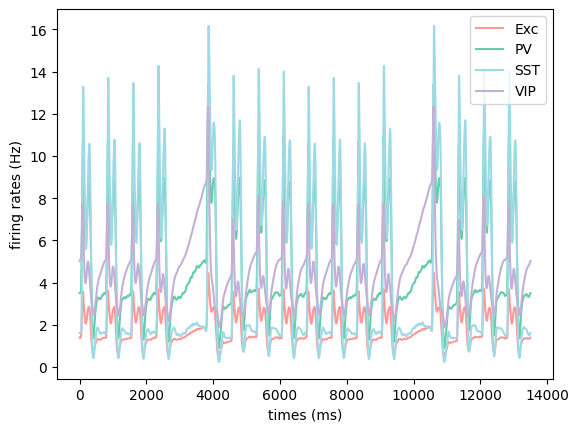

In [5]:
from bmtk.analyzer.firing_rates import plot_rates

import matplotlib as mpl
from cycler import cycler


# For visualization
line_cols = {  # copied form project_colors in util
    "Sst-IRES-Cre": (158 / 255, 218 / 255, 229 / 255),
    "sst": (158 / 255, 218 / 255, 229 / 255),
    "Slc17a7-IRES2-Cre": (255 / 255, 152 / 255, 150 / 255),
    "slc": (255 / 255, 152 / 255, 150 / 255),
    "Vip-IRES-Cre": (197 / 255, 176 / 255, 213 / 255),
    "vip": (197 / 255, 176 / 255, 213 / 255),
}
color_list = [line_cols["slc"], "mediumaquamarine", line_cols["sst"], line_cols["vip"]]
mpl.rcParams["axes.prop_cycle"] = cycler(color=color_list)

plot_rates('config.simulation.json', label_column='pop_name')

## Firing Rates File

### CSV File

When writing or reading a firing-rates file PopNet is expecting a space-separated csv file with at least columns "node_id" (integer) and "firing_rates" (float). The format may also include other optional columns that can be used to identify and cluster populations

In [6]:
import pandas as pd

l23_rates_df = pd.read_csv('output/l23_rates.csv', sep=' ')
l23_rates_df.head()

,population,node_id,timestamps,firing_rates,pop_name
0,l23,0,0.0,1.388537,Exc
1,l23,0,1.0,1.388849,Exc
2,l23,0,2.0,1.388839,Exc
3,l23,0,3.0,1.388825,Exc
4,l23,0,4.0,1.388349,Exc


In [7]:
# Get the firing rates averages
l23_rates_df.groupby(['population', 'pop_name'])['firing_rates'].agg('sum')/sim.tstop

population  pop_name
l23         Exc         1.738432
            PV          4.813858
            SST         4.094843
            VIP         4.535815
Name: firing_rates, dtype: float64

### HDF5 File

Another option is to save and load rates from a SONATA formated HDF5 file.

Rates will be saved by **population** (if there are multiple recurrent networks in the simualtion there will be multiple subgroups) under the group **/rates/{population}/**. The **data** dataset contains a $T \times N$ (where $T$ is the number of timesteps, $N$ the number of nodes) matrix where each column represents the recording firing-rate dynamics for each node. And the **mapping** group contains ways of mapping individual times and keys/attributes to the rows and columns, respectivly.

In [8]:
import h5py

# Will parse and show the rates hdf5 tree
def tree_recurse(h5_obj, depth):
    indent = '   '*(depth-1) + '|--'

    for key, node in h5_obj.items():
        if isinstance(node, h5py.Group):
            print(f'{indent}*{key}/')
            tree_recurse(node, depth=depth+1)
        elif isinstance(node, h5py.Dataset):
            print(f'{indent}>[{key}] {node.shape}')


h5_root = h5py.File('output/l23_rates.h5', 'r')
print('l23_rates.h5/')
tree_recurse(h5_root, depth=1)

l23_rates.h5/
|--*rates/
   |--*l23/
      |-->[data] (13500, 4)
      |--*mapping/
         |-->[node_ids] (4,)
         |-->[pop_name] (4,)
         |-->[time] (13500,)


In [9]:
# How to calcuate firing rate averages from the h5 file
with h5py.File('output/l23_rates.h5', 'r') as h5:
    for pname, pgrp in h5['/rates/'].items():
        node_ids = pgrp['mapping/pop_name'][()].astype(str)
        time = pgrp['mapping/time'][-1]
        print(pname)
        for idx, nid in enumerate(node_ids):
            fr_avg = np.sum(pgrp['data'][:, idx])/time
            print(f'  {nid}: {fr_avg}')

l23
  Exc: 1.738561101541575
  PV: 4.814214600421233
  SST: 4.095146474363797
  VIP: 4.5361512436614


[OPTIONAL]

[**See the next section, Ch 4.1A**](./4.1A%20PopNet%20Optimization.ipynb), for a quick tutorial on how to find and optimize Pop network parameters for your model

[**Proceed to Chapter 5**](../Ch5_filternet/5.%20FilterNet.ipynb)